Final Project

The dataset we're going to use is from https://www.kaggle.com/wojtekbonicki/bitcoin-data. This dataset recorded the bitcoin price and other related data from 12.2014 to 04.2020

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
fc = lambda x: datetime.datetime.strptime(x,"%Y-%m-%d")
data = pd.read_csv('Bitcoin_dataset_updated.csv', index_col = 'Date', parse_dates = True, date_parser = fc)
data.head()

,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
Date,,,,,,,,
2014-01-02,749.27,54770.0,0.18,8,1225.0,1831.98,95.14,11089.3
2014-01-03,781.23,60980.0,NaN,8,1238.4,1831.37,93.66,11089.3
2014-01-04,807.39,52052.0,NaN,8,NaN,NaN,NaN,11089.3
2014-01-05,828.74,58662.0,0.38,8,NaN,NaN,NaN,11089.3
2014-01-06,904.98,67358.0,NaN,8,1237.8,1826.77,93.12,11089.3


In [ ]:
data.fillna(method = 'ffill', inplace=True)
data.isnull().sum()

BTC price [USD]                           0
n-transactions                            0
fee [USD]                                 0
btc search trends                         0
Gold price[USD]                           0
SP500 close index                         0
Oil WTI price[USD]                        0
M2(Not seasonally adjusted)[1e+09 USD]    0
dtype: int64

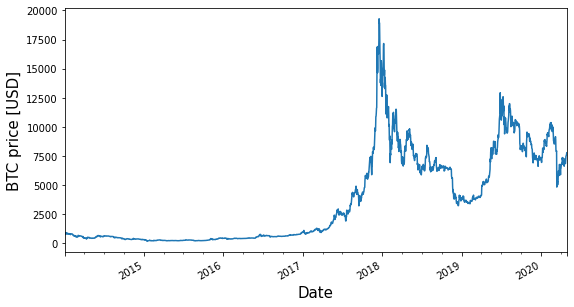

In [ ]:
for i in data.columns[:1]:
    fig,ax = plt.subplots(figsize = (9, 5))      
    data[i].plot(kind = 'line', ax=ax)
    plt.gcf().autofmt_xdate()
    ax.set_xlabel('Date', fontsize = 15)
    ax.set_ylabel(str(i), fontsize = 15)
    plt.show()

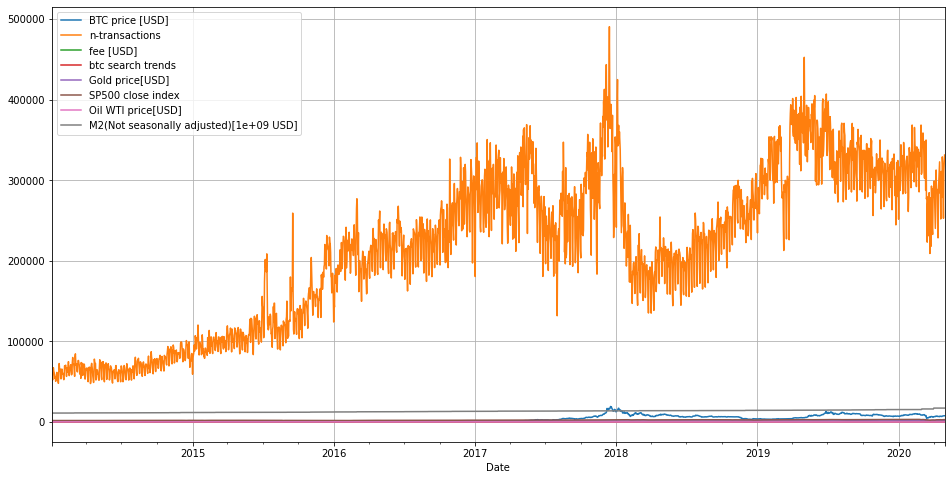

In [ ]:
data.plot(figsize=(16,8))
plt.grid()

In [ ]:
def min_max_std(df):
    for factor in df.columns:
        min = df[factor].min()
        max = df[factor].max()
        df[factor] = ((df[factor] - min) / (max-min)).tolist()
    return df
min_max_std(data)

,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
Date,,,,,,,,
2014-01-02,0.030211,0.015873,0.002739,0.061224,0.220885,0.054791,0.911613,0.0
2014-01-03,0.031884,0.029894,0.002739,0.061224,0.240080,0.054420,0.901401,0.0
2014-01-04,0.033253,0.009736,0.002739,0.061224,0.240080,0.054420,0.901401,0.0
2014-01-05,0.034370,0.024660,0.006392,0.061224,0.240080,0.054420,0.901401,0.0
2014-01-06,0.038360,0.044294,0.006392,0.061224,0.239221,0.051622,0.897675,0.0
...,...,...,...,...,...,...,...,...
2020-04-25,0.383877,0.526220,0.013148,0.142857,0.952299,0.665862,0.365487,1.0
2020-04-26,0.386098,0.463064,0.010774,0.142857,0.952299,0.665862,0.365487,1.0
2020-04-27,0.393935,0.594885,0.012053,0.142857,0.935396,0.691247,0.339129,1.0


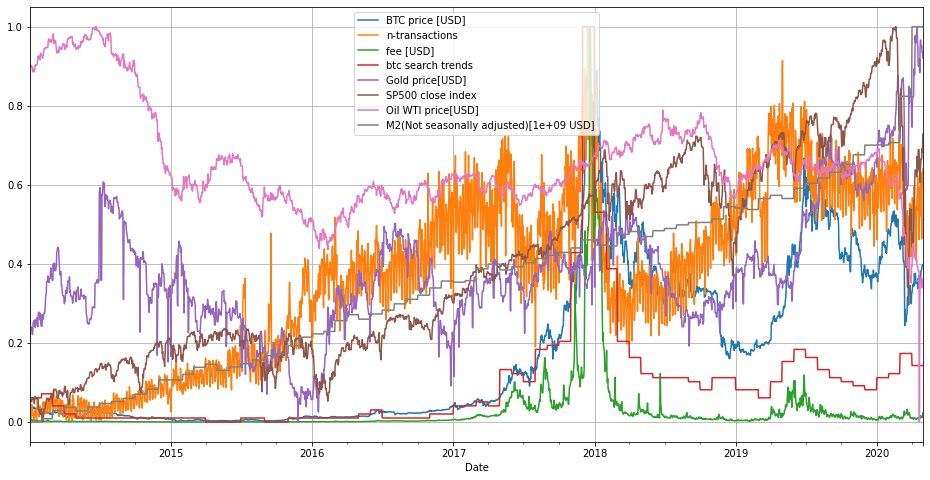

In [ ]:
data.plot(figsize=(16,8))
plt.grid()

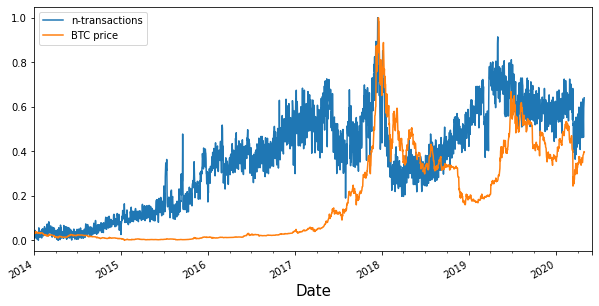

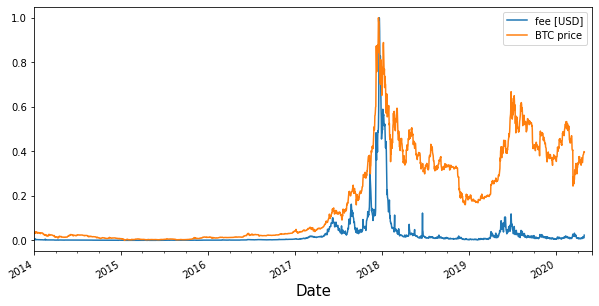

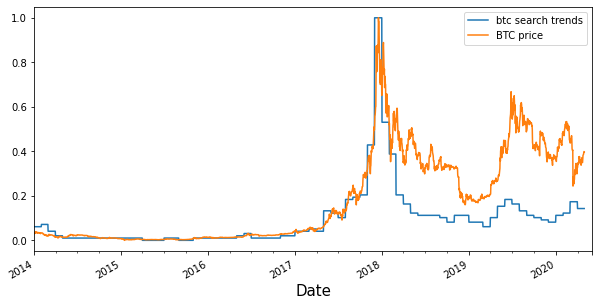

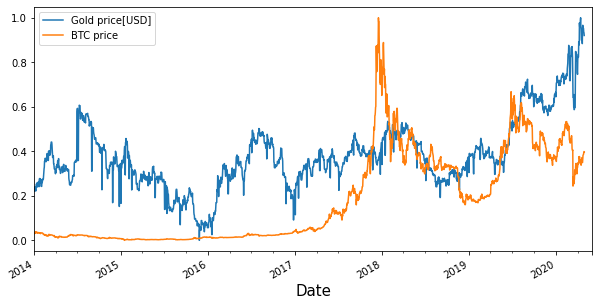

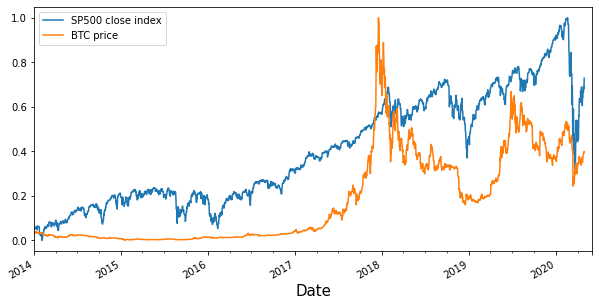

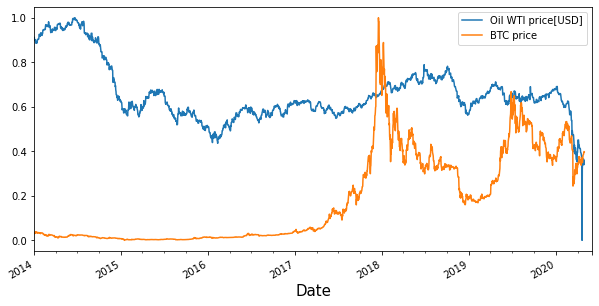

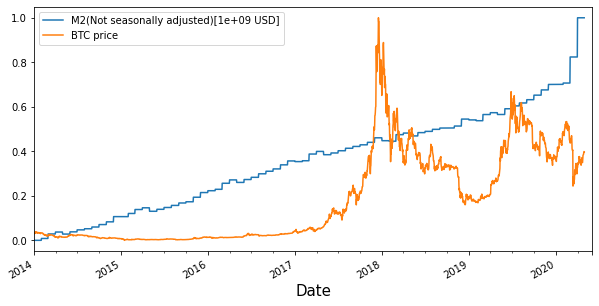

In [ ]:
datemin = datetime.date(data.index.min().year, data.index.min().day-1, 1)
datemax = datetime.date(data.index.max().year, data.index.max().month + 2, 1)  
for i in data.iloc[:,1:].columns:
    fig, ax = plt.subplots(figsize = (10, 5))
    data[i].plot(ax = ax, label = i)
    data.iloc[:,0].plot(ax = ax, label = 'BTC price')
    plt.gcf().autofmt_xdate()
    ax.set_xlabel('Date', fontsize = 15)
    ax.set_xlim([datemin, datemax])
    ax.legend()
    plt.show()

In [ ]:
data = pd.DataFrame(data,columns=data.columns)
data.drop(['M2(Not seasonally adjusted)[1e+09 USD]', 'Oil WTI price[USD]','SP500 close index'],axis=1)
print(data)

            BTC price [USD]  ...  M2(Not seasonally adjusted)[1e+09 USD]
Date                         ...                                        
2014-01-02         0.030211  ...                                     0.0
2014-01-03         0.031884  ...                                     0.0
2014-01-04         0.033253  ...                                     0.0
2014-01-05         0.034370  ...                                     0.0
2014-01-06         0.038360  ...                                     0.0
...                     ...  ...                                     ...
2020-04-25         0.383877  ...                                     1.0
2020-04-26         0.386098  ...                                     1.0
2020-04-27         0.393935  ...                                     1.0
2020-04-28         0.398718  ...                                     1.0
2020-04-29         0.397392  ...                                     1.0

[2310 rows x 8 columns]


In [ ]:
real_price = data['BTC price [USD]']

In [ ]:
# split data
df_train=real_price[:int(len(real_price)*0.7)]
df_test=real_price[int(len(real_price)*0.7):]

In [ ]:
# Data preprocess
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))
#test set
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))
X_test = test_set[0:len(test_set)-1]
y_test = test_set[1:len(test_set)]
X_test = np.reshape(X_test, (len(X_test), 1, 1))


In [ ]:
# Initialising the RNN
regressor = Sequential()

# Adding the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a forth RNN and some Dropout regularisation
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train,validation_data=(X_test,y_test), epochs = 100, batch_size = 32)
# epoch= 250

Epoch 1/100
51/51 [==============================] - 4s 16ms/step - loss: 0.0082 - accuracy: 0.0012 - val_loss: 3.0157e-04 - val_accuracy: 0.0000e+00
Epoch 2/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0030 - accuracy: 0.0012 - val_loss: 5.2175e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0030 - accuracy: 0.0012 - val_loss: 2.7706e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0029 - accuracy: 0.0012 - val_loss: 9.3128e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.0012 - val_loss: 3.8188e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0024 - accuracy: 0.0012 - val_loss: 3.1034e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0022 - accuracy: 0.0012 - val_

In [ ]:
predicted_btc_price = regressor.predict(X_test)

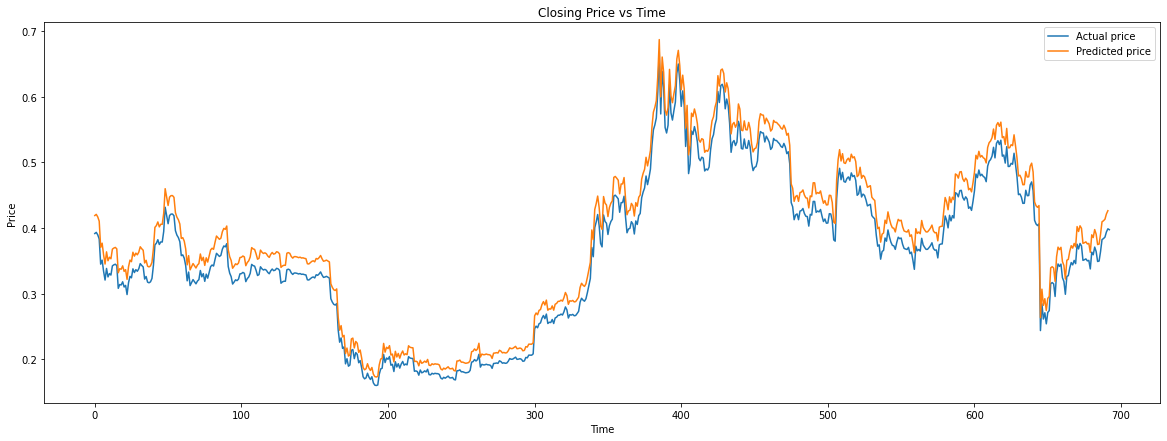

In [ ]:
plt.figure(figsize = (20,7))
plt.plot(test_set)
plt.plot(predicted_btc_price)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Closing Price vs Time')
plt.legend(['Actual price', 'Predicted price'])
plt.show()

In [ ]:
mae1=(sum(abs(y_test-predicted_btc_price)))/len(X_test)
print(mae1)

[0.02537201]


In [ ]:
model2 = Sequential()
model2.add(LSTM(50,activation="sigmoid",input_shape=(1,1)))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test),batch_size=32, verbose=2)

Epoch 1/100
51/51 - 2s - loss: 0.0640 - accuracy: 6.1881e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00 - 2s/epoch - 33ms/step
Epoch 2/100
51/51 - 0s - loss: 0.0625 - accuracy: 6.1881e-04 - val_loss: 0.0631 - val_accuracy: 0.0000e+00 - 152ms/epoch - 3ms/step
Epoch 3/100
51/51 - 0s - loss: 0.0493 - accuracy: 6.1881e-04 - val_loss: 0.0651 - val_accuracy: 0.0000e+00 - 189ms/epoch - 4ms/step
Epoch 4/100
51/51 - 0s - loss: 0.0453 - accuracy: 6.1881e-04 - val_loss: 0.0449 - val_accuracy: 0.0000e+00 - 167ms/epoch - 3ms/step
Epoch 5/100
51/51 - 0s - loss: 0.0431 - accuracy: 6.1881e-04 - val_loss: 0.0498 - val_accuracy: 0.0000e+00 - 205ms/epoch - 4ms/step
Epoch 6/100
51/51 - 0s - loss: 0.0386 - accuracy: 6.1881e-04 - val_loss: 0.0380 - val_accuracy: 0.0000e+00 - 160ms/epoch - 3ms/step
Epoch 7/100
51/51 - 0s - loss: 0.0364 - accuracy: 6.1881e-04 - val_loss: 0.0409 - val_accuracy: 0.0000e+00 - 199ms/epoch - 4ms/step
Epoch 8/100
51/51 - 0s - loss: 0.0338 - accuracy: 6.1881e-04 - val_loss: 0.045

In [ ]:
predicted_btc_price2 = regressor.predict(X_test)

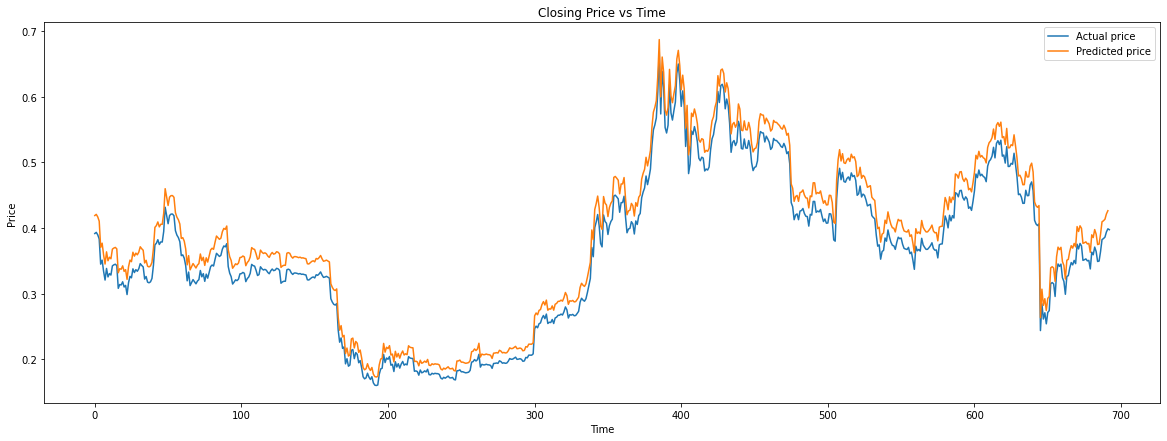

In [ ]:
plt.figure(figsize = (20,7))
plt.plot(test_set)
plt.plot(predicted_btc_price2)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Closing Price vs Time')
plt.legend(['Actual price', 'Predicted price'])
plt.show()

In [ ]:
mae2=sum(abs(y_test-predicted_btc_price2))/len(X_test)
print(mae2)

[0.02537201]
